Load DATA 

In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from pgmpy.inference import VariableElimination  # Import VariableElimination from pgmpy.inference
import matplotlib.pyplot as plt
import networkx as nx


In [4]:
dataset_path = "Mental Health Dataset.csv"
df = pd.read_csv(dataset_path, sep=';')

In [5]:

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():  # Check if there are missing values in the column
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values with mode

# Save the dataset with filled missing values to a CSV file
df.to_csv("filled_dataset.csv", index=False)


# PERFORM ONE HOT ENCODING

In [53]:
# Load the dataset (if not already loaded)
file_path = "filled_dataset.csv"  # Replace "filled_dataset.csv" with the path to your filled dataset
df_filled = pd.read_csv(file_path)

# Shuffle the dataset
df_filled = df_filled.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables using label encoding
categorical_cols = df_filled.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_filled[col] = label_encoder.fit_transform(df_filled[col])

# Display the encoded dataset
df_filled.to_csv("filled_dataset_encoding.csv", index=False)

# Now we get Test,Validation and Train data

In [54]:
# Define the desired sizes for the reduced datasets
train_data = df_filled[:7000]
val_data = df_filled[1000:6000]
test_data = df_filled[2000:6000]


# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (7000, 17)
Validation data shape: (5000, 17)
Test data shape: (4000, 17)


# DEFINING THE MODEL

In [44]:
# Define the structure of the Bayesian network
edges = [
    ('Gender', 'treatment'),
    ('Country', 'treatment'),
    ('Occupation', 'treatment'),
    ('self_employed', 'treatment'),
    ('family_history', 'treatment'),
    ('Days_Indoors', 'treatment'),
    ('Growing_Stress', 'treatment'),
    ('Changes_Habits', 'treatment'),
    ('Mental_Health_History', 'treatment'),
    ('Mood_Swings', 'treatment'),
    ('Coping_Struggles', 'treatment'),
    ('Work_Interest', 'treatment'),
    ('Social_Weakness', 'treatment'),
    ('mental_health_interview', 'treatment'),
    ('care_options', 'treatment')
]


# TRAINING THE MODEL

In [57]:
# Initialize BayesianModel
model = BayesianNetwork(edges)

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# PREDICTING THE MODEL

In [58]:
# Perform inference for treatment outcome prediction
inference = VariableElimination(model)  # Assuming `model` is your trained Bayesian network model

# Function to predict treatment outcome for a given dataset
def predict_treatment_outcome(data):
    y_pred = []
    for _, row in data.iterrows():
        evidence = row.drop(['treatment', 'Timestamp']).to_dict()
        # Perform inference using VariableElimination
        query_result = inference.query(variables=['treatment'], evidence=evidence)
        # Extract the probability of the positive class (treatment)
        prob_treatment = query_result.values[1]
        # Compare the probability of treatment with a threshold (e.g., 0.5)
        y_pred.append(prob_treatment > 0.5)
    return y_pred

# Predict treatment outcome for the validation set
val_y_pred = predict_treatment_outcome(val_data)
val_y_true = val_data['treatment']

# Predict treatment outcome for the test set
test_y_pred = predict_treatment_outcome(test_data)
test_y_true = test_data['treatment']

# Calculating evaluation metrics

In [60]:
# Calculate evaluation metrics
accuracy = accuracy_score(val_y_true, val_y_pred)
precision = precision_score(val_y_true, val_y_pred)
recall = recall_score(val_y_true, val_y_pred)
f1 = f1_score(val_y_true, val_y_pred)
roc_auc = roc_auc_score(val_y_true, val_y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9376
Precision: 0.9793902962644911
Recall: 0.8962671905697446
F1-score: 0.9359868691013541
ROC AUC: 0.9383576278714304


# BAYESIAN NETWORK DIAGRAM

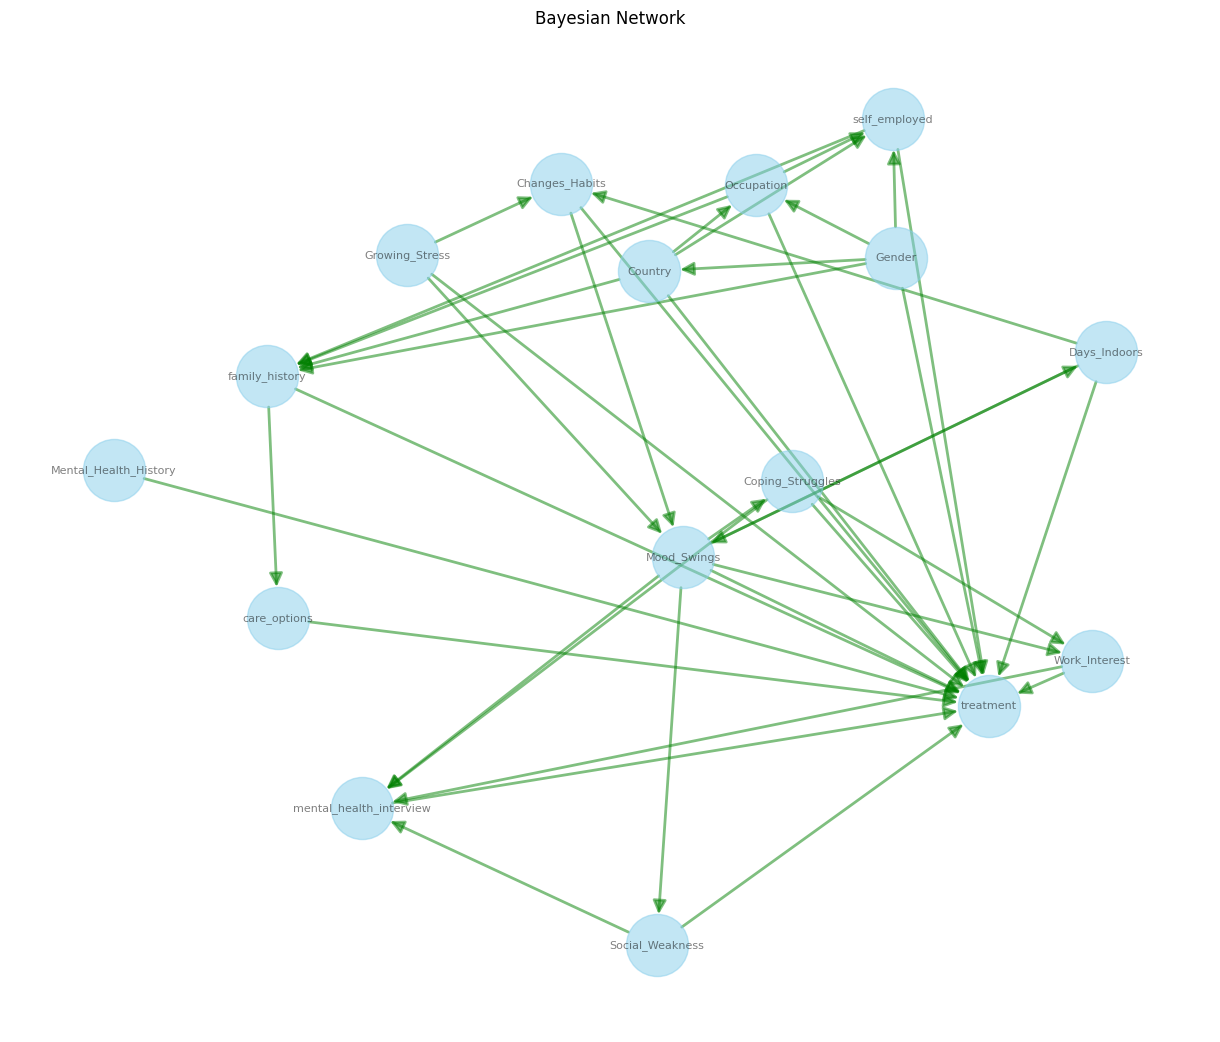

In [85]:
edges1 = [
    ('Gender', 'treatment'),
    ('Country', 'treatment'),
    ('Occupation', 'treatment'),
    ('self_employed', 'treatment'),
    ('family_history', 'treatment'),
    ('Days_Indoors', 'treatment'),
    ('Growing_Stress', 'treatment'),
    ('Changes_Habits', 'treatment'),
    ('Mental_Health_History', 'treatment'),
    ('Mood_Swings', 'treatment'),
    ('Coping_Struggles', 'treatment'),
    ('Work_Interest', 'treatment'),
    ('Social_Weakness', 'treatment'),
    ('mental_health_interview', 'treatment'),
    ('care_options', 'treatment'),
    ('Gender', 'Country'),
    ('Gender', 'Occupation'),
    ('Gender', 'self_employed'),
    ('Gender', 'family_history'),
    ('Country', 'Occupation'),
    ('Country', 'self_employed'),
    ('Country', 'family_history'),
    ('Occupation', 'self_employed'),
    ('Occupation', 'family_history'),
    ('self_employed', 'family_history'),
    ('Growing_Stress', 'Changes_Habits'),
    ('Growing_Stress', 'Mood_Swings'),
    ('Changes_Habits', 'Mood_Swings'),
    ('Mood_Swings', 'Coping_Struggles'),
    ('Mood_Swings', 'Work_Interest'),
    ('Mood_Swings', 'Social_Weakness'),
    ('Mood_Swings', 'mental_health_interview'),
    ('Coping_Struggles', 'Work_Interest'),
    ('Coping_Struggles', 'mental_health_interview'),
    ('Work_Interest', 'mental_health_interview'),
    ('Social_Weakness', 'mental_health_interview'),
    ('family_history', 'care_options'),
    ('Days_Indoors', 'Changes_Habits'),
    ('Days_Indoors', 'Mood_Swings'),
    ('Mood_Swings', 'Days_Indoors'),
    ('Mood_Swings', 'Social_Weakness')
]

# Create BayesianNetwork object
model = BayesianNetwork(edges1)

# Visualize the Bayesian Network structure using networkx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=8, arrowsize=20)
plt.title("Bayesian Network")
plt.show()